In [1]:
import numpy as np
from scipy.optimize import curve_fit
import scipy.constants as const
import pandas as pd
import matplotlib.pyplot as plt 

In [155]:
def volt_freq_read(file_name='day_1_resistor_test\D1full100khzspan.CSV', low_freq=0, high_freq=400):
    datapoints = pd.read_csv(file_name, header=None)
    freq=datapoints[0].tolist()
    volt = datapoints[1].tolist()
    
    xdata=np.array(freq[low_freq:high_freq])
    ydata=np.array(volt[low_freq:high_freq])
    return xdata, ydata

def gaussian_test(x, amp0, mu0, sigma0):
    return amp0*np.exp(((x-mu0)/sigma0)**2 /(-2))/((2*np.pi)**(0.5)*sigma0)

def linear_test(x, slope, intercept):
    return intercept + x*slope

def gain_fit(freq, volt, low_freq = 4, high_freq=200):
    xdata = freq[low_freq:high_freq]
    ydata = volt[low_freq:high_freq]
    
    background = 5*10**(-5)#np.min(ydata)
    amplitude = np.max(ydata)-background
    mean = sum(xdata * ydata) / sum(ydata)
    sdeviation = np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
    
    popt, pcov = curve_fit(gaussian_test, xdata, ydata, \
                           p0=[amplitude, mean, sdeviation], maxfev=100000)
    y_fit=gaussian_test(freq, *popt)

    print(popt)
    return y_fit

def average_gain():
    v_out = np.array([0]*400)
    v_in = np.array([0]*400)
    fg, _ = volt_freq_read('day_4_gain\D4G'+'0'+'.csv')
    _, vb1 = volt_freq_read('day_4_res\D4'+'N'+'.csv')
    _, vb2 = volt_freq_read('day_5_gain\D5'+'N0'+'.csv')
    #_, vb = volt_freq_read('day_1_resistor_test\D1noiseonly.CSV')#'day_4_n_2\D4'+'S'+'.csv')
    vb_avg1 = np.mean(vb1[11:42])
    vb_avg2 = np.mean(vb2[11:42])
    vb_avg = np.mean([vb_avg1,vb_avg2])
    for i in range(3):
        _, vg = volt_freq_read('day_4_gain\D4G'+str(i)+'.csv')
        _, vrg = volt_freq_read('day_4_gain\D4R'+str(i)+'.csv')
        v_out = v_out + vg
        v_in = v_in + vrg
    # # block out background noise

    
    # _, v_out = volt_freq_read('day_5_gain\D5'+'A0'+'.csv')
    # _, v_in = volt_freq_read('day_5_gain\D5'+'N0'+'.csv')
    v_out = (v_out/3) - vb_avg
    v_in = (v_in/3)  - vb_avg    
    v_gain = (v_out/v_in)
    v_err = v_out*1.035142*0.02*10**(-2)
    gain_err = (2 * v_gain * np.sqrt(1+v_gain) / v_in) * v_err
    gf = gain_fit(fg, v_gain**2, 11,42)
    return v_gain**2, gf, gain_err

def band_gain(cap,res, gf, freq, gain_err):
    G = 0
    dG_R = 0
    dG_g = 0
    d_f = freq[1]-freq[0]
    d_g = gain_err
    d_R = 0.01 * res
    # 3 to 10 kHz
    for i in range(12,41):
        G = G + (0.5 * (gf[i-1]+gf[i+1]) * d_f)/(1 + (2 * np.pi * freq[i] * cap * res)**2)
        dG_g = dG_g + (2 * np.sqrt(gf[i]) * d_f * d_g[i]) / (1 + (2 * np.pi * freq[i] * cap * res)**2)
        dG_R = dG_R + (gf[i] * d_f * d_R) * (4 * np.pi * freq[i] * cap * res)**2 / (1 + (2 * np.pi * freq[i] * cap * res)**2)**2
    #print(G)
    dG = G*np.sqrt(30*(np.mean(gain_err) /(np.mean(gf)))**2+2*(0.01)**2)#(dG_g*d_g[0])**2)#+(dG_R*d_R)**2)
    return G, dG

In [3]:
G_test = 0
d_f = 250

v_gain, gain_fitted = average_gain() 
for i in range(12,41):
    G_test = G_test + gain_fitted[i]*d_f
print(G_test*10**(-10))
    

[3.16311855e+10 5.85351007e+03 2.80898116e+03]
2.5035362344326484


## Row Data Plot

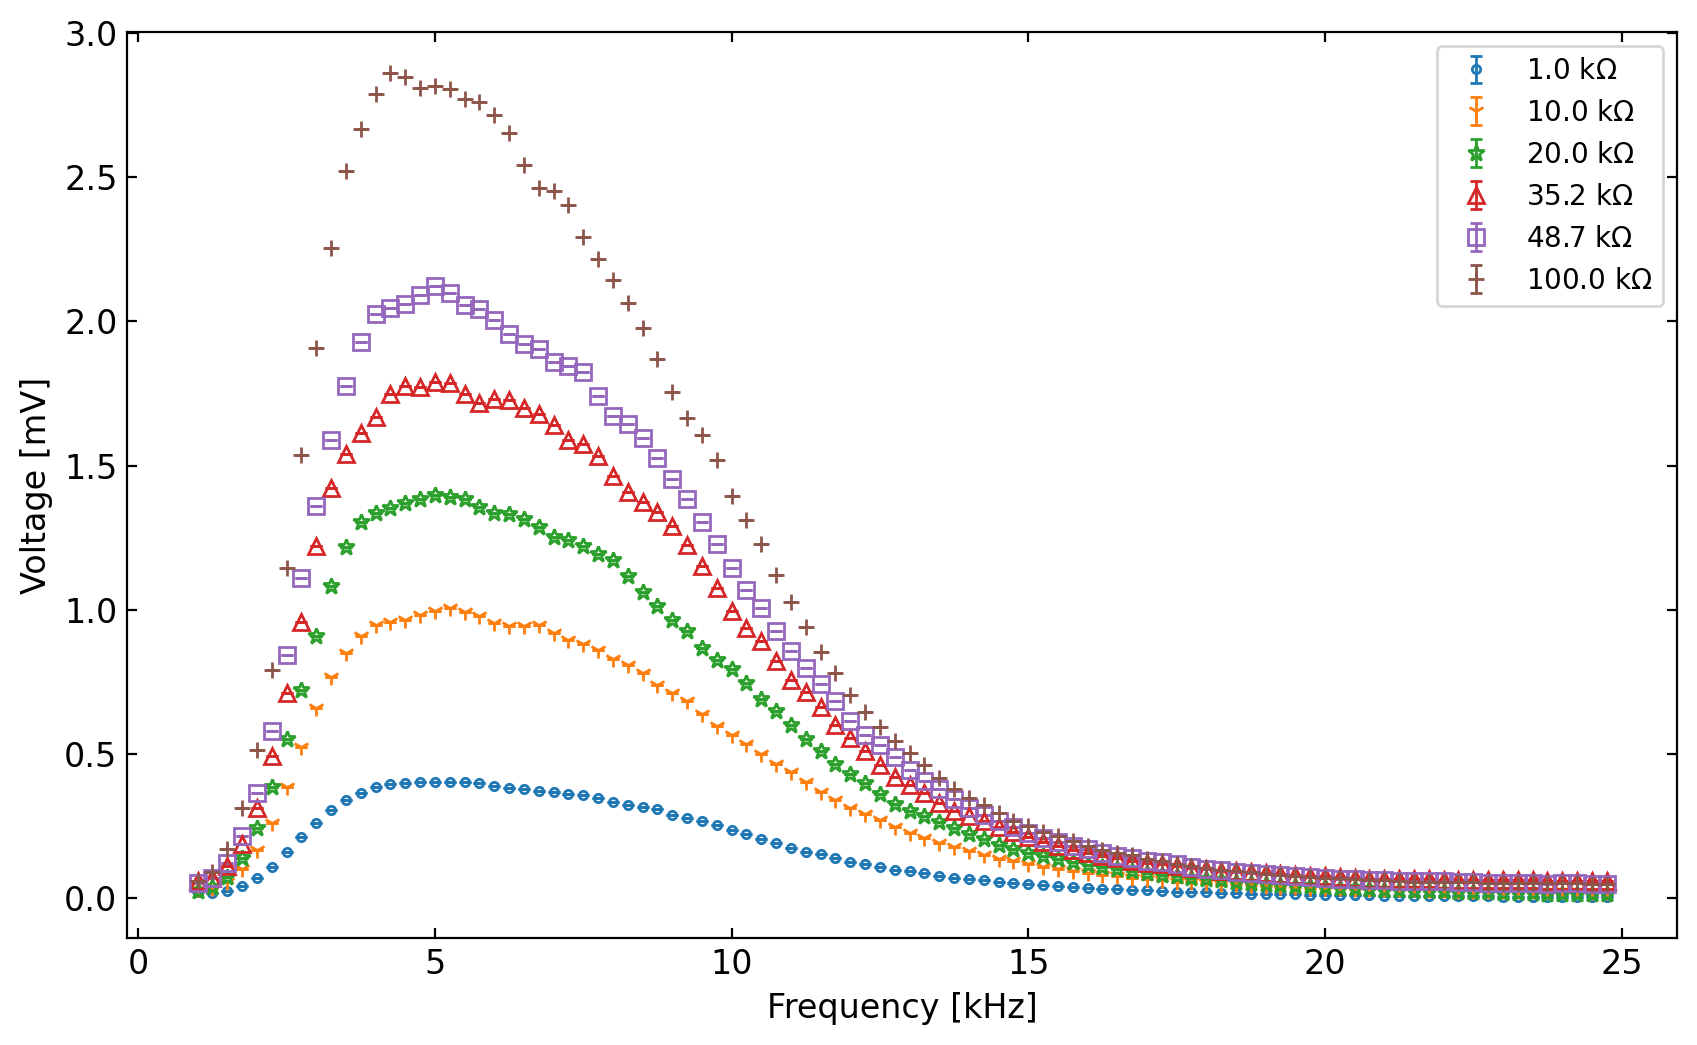

In [225]:
res_data_list = np.array([1,10,20,352,487,100])
res_label_list = np.array([1,10,20,35.2,48.7,100])
fmt_list = ['.', '1', '*', '^', 's', '+']
#fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharey=False,figsize=(20, 10))
plt.figure(figsize=(10,6), dpi = 200)

for i in range(len(res_data_list)):
    
    fres, vres = volt_freq_read('day_4_res\D4'+str(res_data_list[i])+'K.csv')
    plt.errorbar(fres[4:100]/1000,vres[4:100]*1000 , yerr = vres[4:100]*1.035142*0.02*10**(-2), fmt=fmt_list[i], mfc = 'none',elinewidth = 1, capsize = 2, label = str(res_label_list[i])+' k$\Omega$')

    
plt.tick_params(bottom=True,top=True,left=True,right=True,direction='in')
plt.xlabel('Frequency [kHz]', fontsize=12)
plt.ylabel('Voltage [mV]',fontsize=12)
#plt.xlim(-20, 2740)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(labels = ['Estimated $S_2$', 'Measured light spot position'], fontsize = 12)
plt.legend()
#plt.title('Voltage Spectra at Room Temperature')
plt.show()

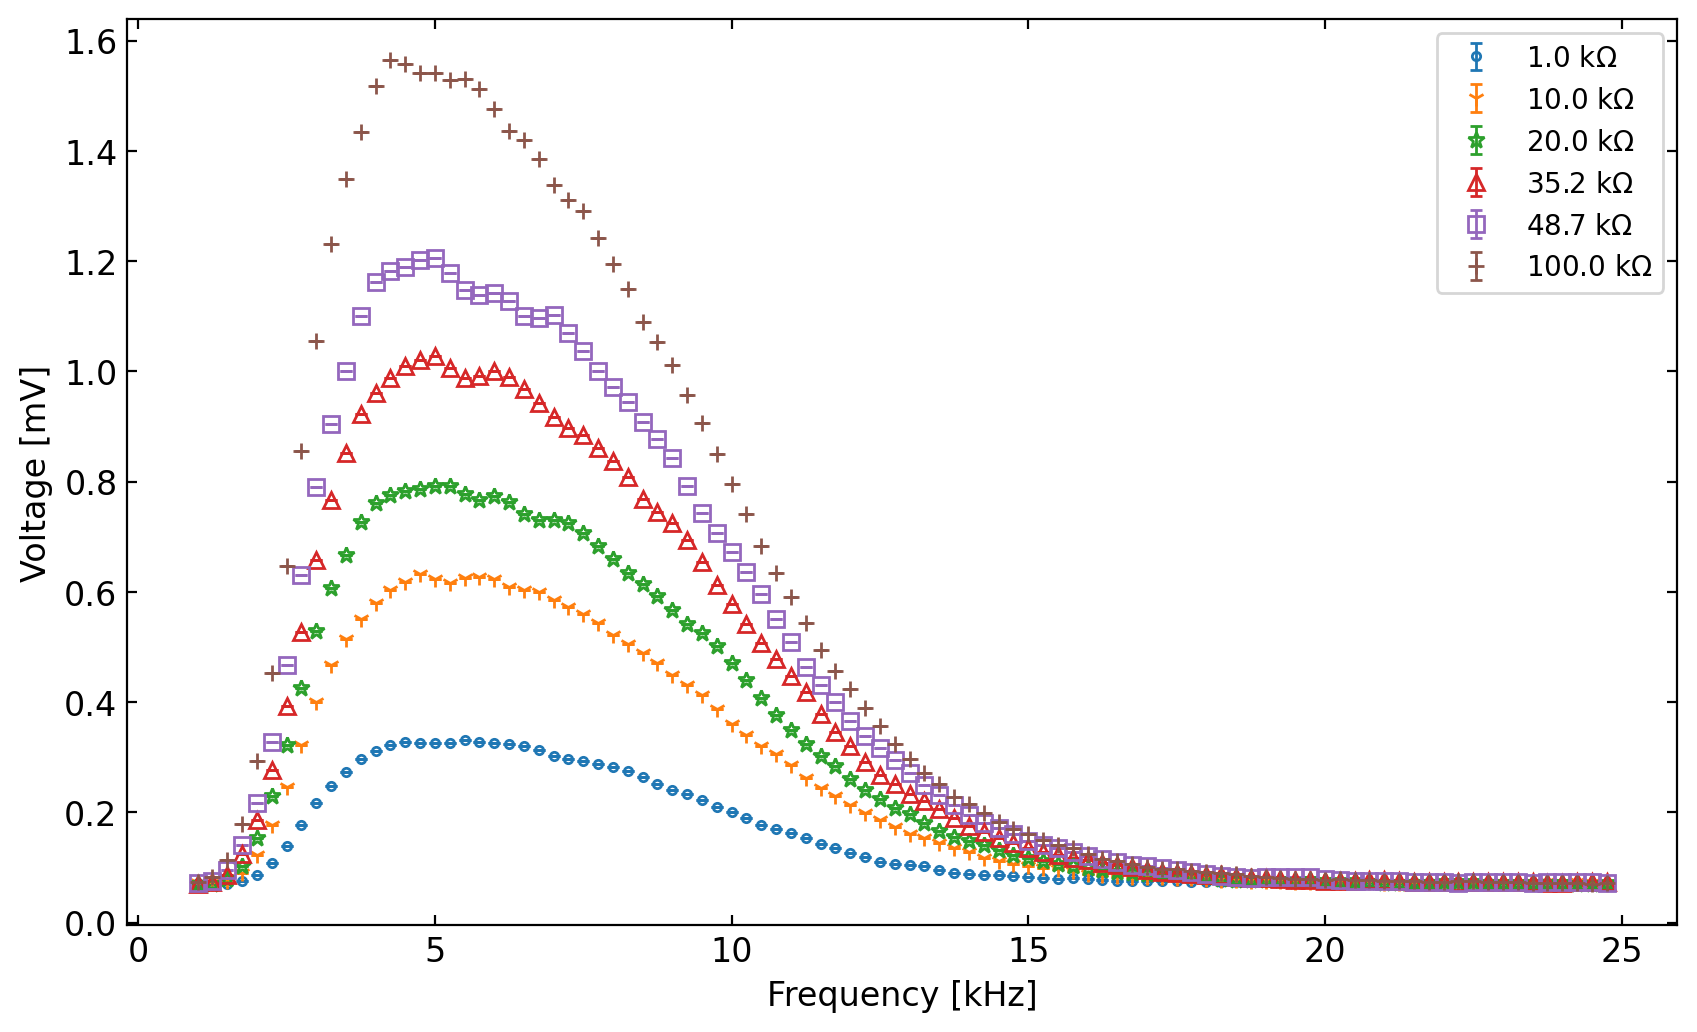

In [226]:

plt.figure(figsize=(10,6), dpi = 200)

for i in range(len(res_data_list)):
    
    fres, vres = volt_freq_read('day_4_n_2\D4'+str(res_data_list[i])+'K.csv')
    plt.errorbar(fres[4:100]/1000,vres[4:100]*1000 , yerr = vres[4:100]*1.035142*0.02*10**(-2), fmt=fmt_list[i], mfc='none',elinewidth = 1, capsize = 2, label = str(res_label_list[i])+' k$\Omega$')

    
plt.tick_params(bottom=True,top=True,left=True,right=True,direction='in')
plt.xlabel('Frequency [kHz]', fontsize=12)
plt.ylabel('Voltage [mV]',fontsize=12)
#plt.xlim(-20, 2740)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(labels = ['Estimated $S_2$', 'Measured light spot position'], fontsize = 12)
plt.legend()
#plt.title('Voltage Spectra at $N_2$ Boiling Point')
plt.show()

## Fit Gain Plot

[7.34499574e+10 5.79983470e+03 2.86875994e+03]


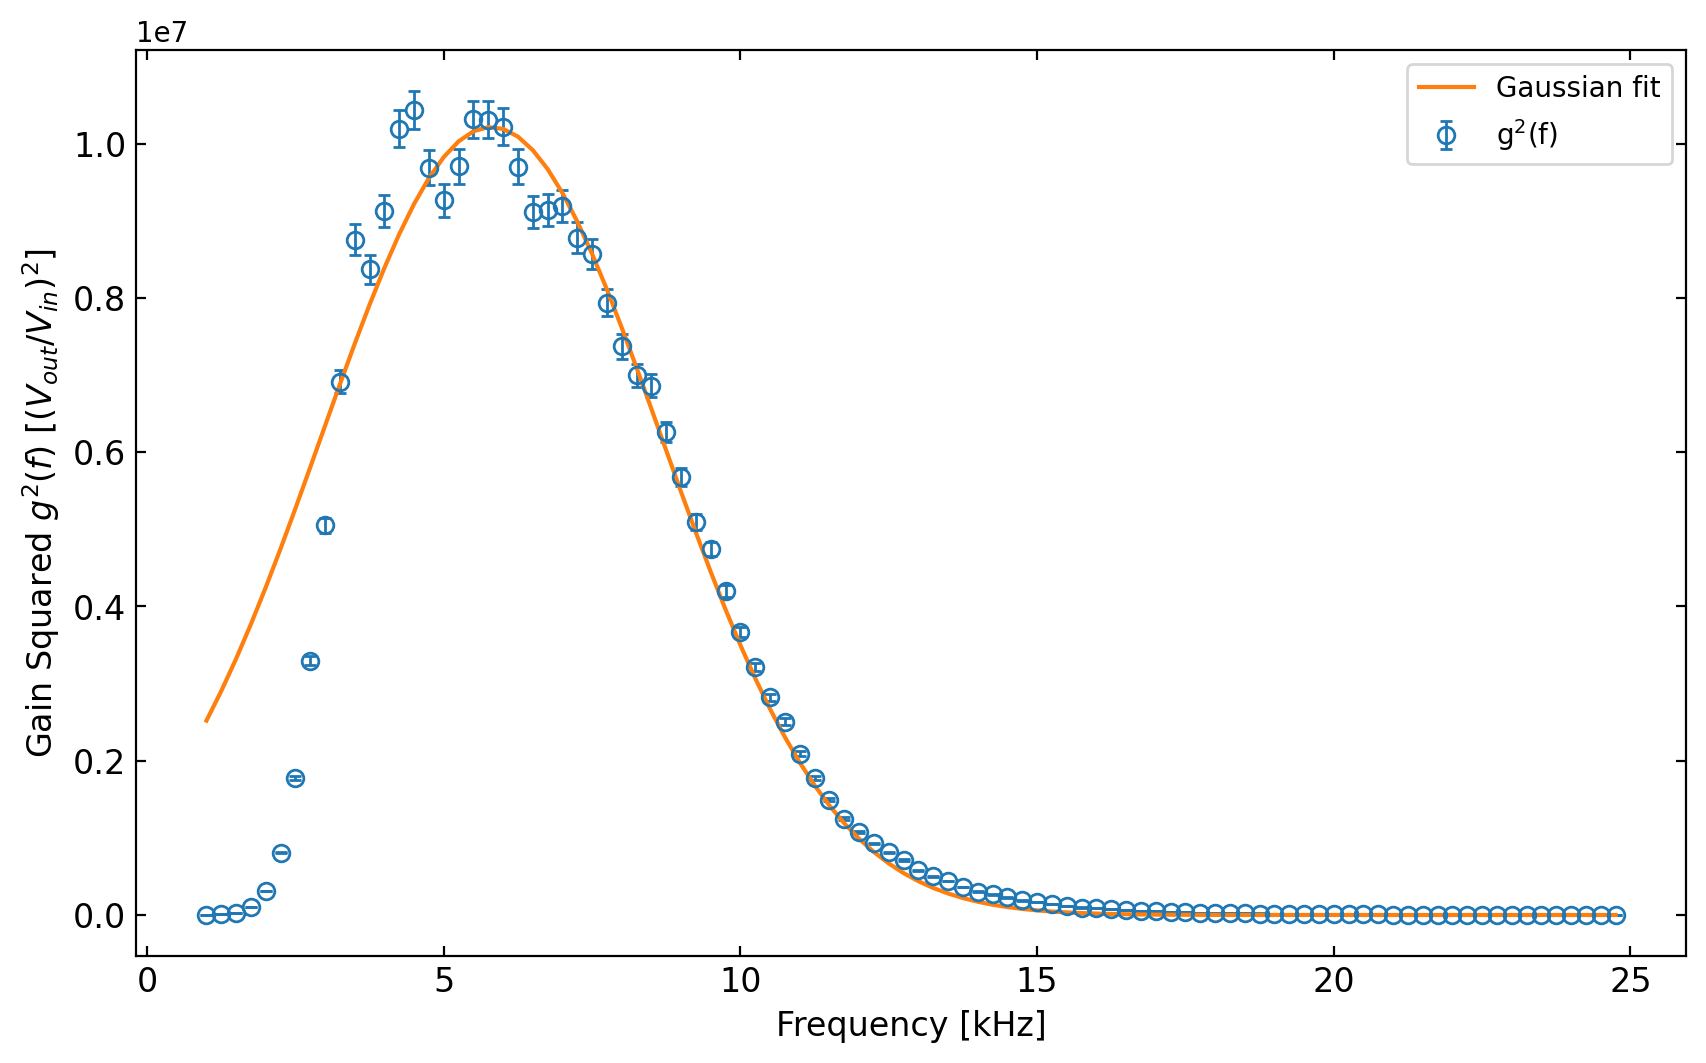

In [227]:
plt.figure(figsize=(10,6), dpi = 200)

fres, _ = volt_freq_read('day_4_gain\D4G'+'0'+'.csv')
v_gain, gain_fitted, gain_err = average_gain()

plt.errorbar(fres[4:100]/1000,v_gain[4:100] , yerr = gain_err[4:100], fmt='o', mfc='none',elinewidth = 1, capsize = 2, label = 'g$^2$(f)')
plt.plot(fres[4:100]/1000, gain_fitted[4:100], label = 'Gaussian fit')

plt.tick_params(bottom=True,top=True,left=True,right=True,direction='in')
plt.xlabel('Frequency [kHz]', fontsize=12)
plt.ylabel('Gain Squared $g^2(f)$ [$(V_{out}/V_{in})^2$]',fontsize=12)
#plt.xlim(-20, 2740)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(labels = ['Estimated $S_2$', 'Measured light spot position'], fontsize = 12)
plt.legend()
#plt.title('Gaussian Fit for Gain Function')
plt.show()

In [94]:
gain_err[10]

20.100711950342998

## Room Temperature Estimation

[7.34499574e+10 5.79983470e+03 2.86875994e+03]
0.10700303971061768
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
0.10700303971061768
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
0.10700303971061768
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
0.10700303971061768
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
0.10700303971061768
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
0.10700303971061768


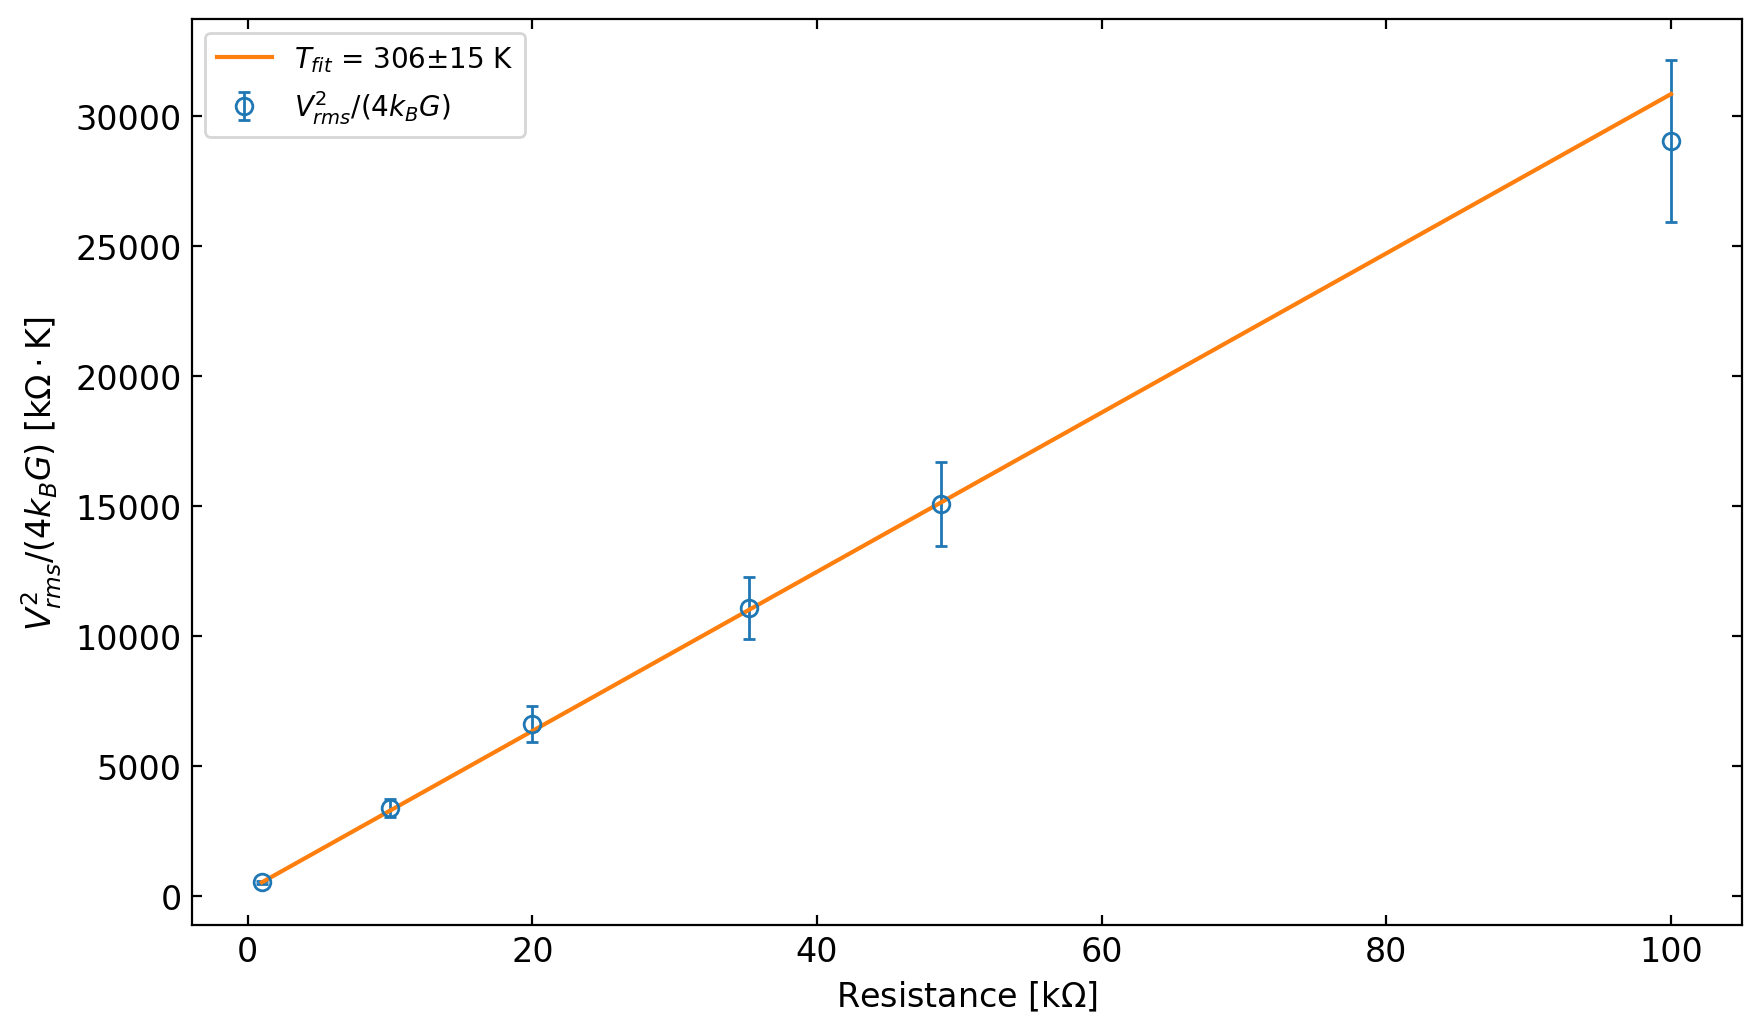

In [228]:
cap = (0.96*93.5085)*10**(-12)
kb = const.k
res_list = np.array([1,10,20,35.2,48.7,100])*10**3
res_data_list = np.array([1,10,20,352,487,100])
factor_list = []
factor_err_list = []
V_ms_r = np.array([1318,3281,4569,5878,6804,9021])*10**(-6)
v_ms_s = 2884*10**(-7)

for i in range(len(res_list)):
    res = res_list[i]
    fres, vres = volt_freq_read('day_4_res\D4'+str(res_data_list[i])+'K.csv')
    v_gain, gf, gain_err = average_gain()
    G_band, G_band_err = band_gain(cap*(1), res, gf, fres, gain_err)
    #V_msb = 0.001318**2
    
    # block out the background noise
    V_ms = V_ms_r[i]**2 - v_ms_s**2 
    
    temp_factor = (V_ms) / (4*kb*G_band)
    temp_factor_err = temp_factor * np.sqrt((0.04*10**(-2))**2+(G_band_err / G_band)**2)
    print(G_band_err/G_band)
    factor_list.append(temp_factor)
    factor_err_list.append(temp_factor_err)

plt.figure(figsize=(10,6), dpi = 200)

popt, pcov = curve_fit(linear_test, res_list, factor_list, sigma=factor_err_list, absolute_sigma=True)
temp_err = np.sqrt(pcov[0][0])
plt.errorbar(res_list/1000, np.array(factor_list)/1000, yerr = np.array(factor_err_list)/1000, fmt='o', mfc='none',elinewidth = 1, capsize = 2, label = '$ V_{rms}^2/(4k_BG) $')
plt.plot(res_list/1000, linear_test(res_list, *popt)/1000, label = '$T_{fit}$ = '+str(int(popt[0]))+'$\pm$'+str(int(temp_err))+' K')

plt.tick_params(bottom=True,top=True,left=True,right=True,direction='in')
plt.xlabel('Resistance [k$\Omega$]', fontsize=12)
plt.ylabel('$ V_{rms}^2/(4k_BG) $ [k$\Omega\cdot$K]',fontsize=12)
#plt.xlim(-20, 2740)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(labels = ['Estimated $S_2$', 'Measured light spot position'], fontsize = 12)
plt.legend()
#plt.title('Linear fit for room temperature')
plt.show()

## Boltzmann Constant Estimation

[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]


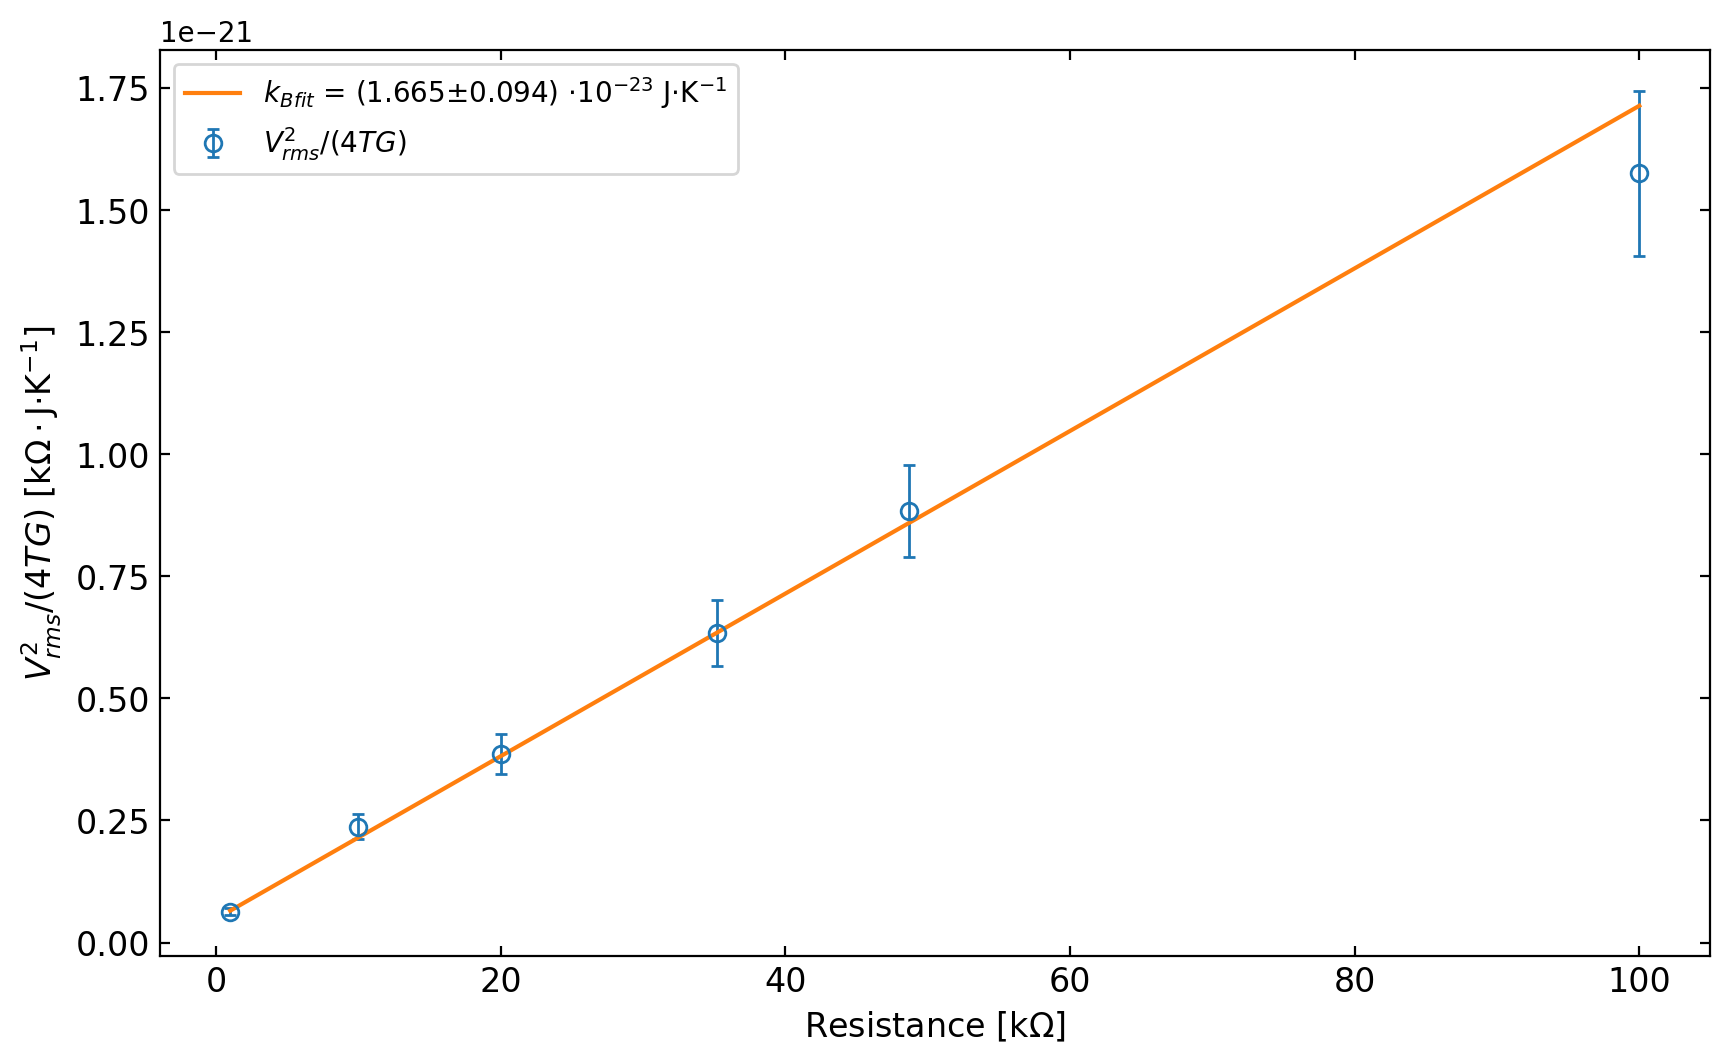

In [233]:
cap = (0.96*93.5085)*10**(-12)
T = 77
res_list = np.array([1,10,20,35.2,48.7,100])*10**3
res_data_list = np.array([1,10,20,352,487,100])
factor_list = []
factor_err_list = []
V_ms_n = np.array([1097,2065,2615,3329,3895,4967])*10**(-6)
v_ms_s = 2884*10**(-7)

for i in range(len(res_list)):
    res = res_list[i]
    fres, vres = volt_freq_read('day_4_res\D4'+str(res_data_list[i])+'K.csv')
    v_gain, gf, gain_err = average_gain()
    G_band, G_band_err = band_gain(cap*(1), res, gf, fres, gain_err)
    #V_msb = 0.001318**2
    
    # block out the background noise
    V_ms = V_ms_n[i]**2 - v_ms_s**2 
    temp_factor = (V_ms) / (4*T*G_band)
    temp_factor_err = temp_factor * np.sqrt((0.04*10**(-2))**2+(G_band_err / G_band)**2)
    factor_list.append(temp_factor)
    factor_err_list.append(temp_factor_err)

plt.figure(figsize=(10,6), dpi = 200)

popt, pcov = curve_fit(linear_test, res_list, factor_list, sigma=factor_err_list, absolute_sigma=True)
boltz_err = np.sqrt(pcov[0][0])
plt.errorbar(res_list/1000, np.array(factor_list)/1000, yerr = np.array(factor_err_list)/1000, fmt='o',mfc='none',elinewidth = 1, capsize = 2, label = '$ V_{rms}^2/(4TG) $')
plt.plot(res_list/1000, linear_test(res_list, *popt)/1000, label = '${k_B}_{fit}$ = ('+str(np.round(popt[0]*10**23,3))+'$\pm$'\
         +str(np.round(boltz_err*10**23,3))+') $\cdot 10^{-23}$ J$\cdot$K$^{-1}$')

plt.tick_params(bottom=True,top=True,left=True,right=True,direction='in')
plt.xlabel('Resistance [k$\Omega$]', fontsize=12)
plt.ylabel('$ V_{rms}^2/(4TG) $ [k$\Omega \cdot$J$\cdot$K$^{-1}$]',fontsize=12)
#plt.xlim(-20, 2740)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(labels = ['Estimated $S_2$', 'Measured light spot position'], fontsize = 12)
plt.legend()
#plt.title('Linear fit for Boltzmann constant')
plt.show()

## Fit Gain and Calculate Temperature

[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
287.07284785192905
room


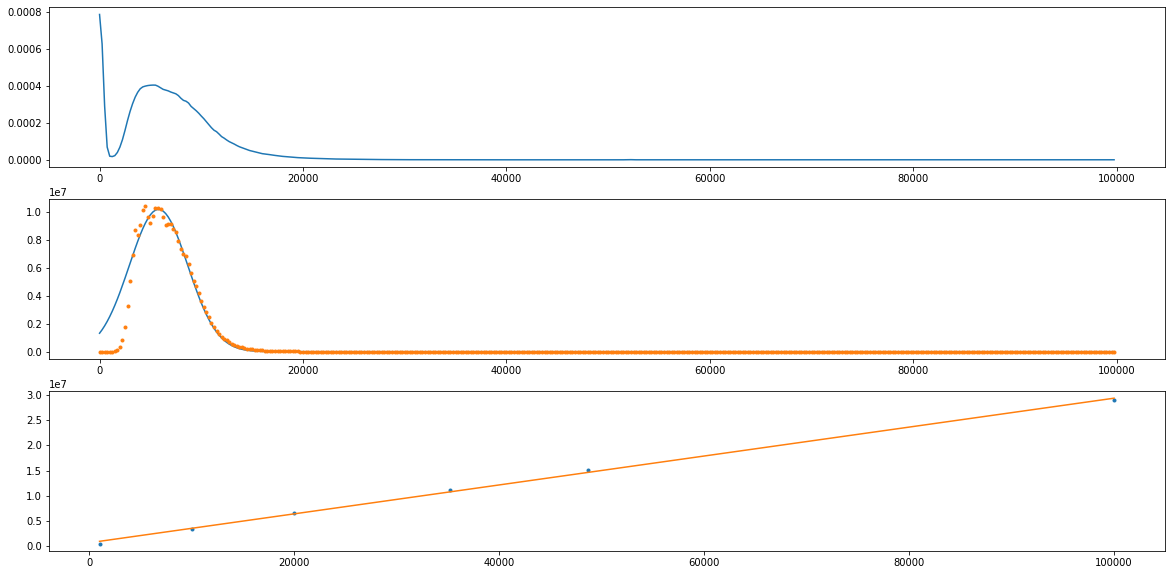

In [75]:
cap = (0.96*93.5085)*10**(-12)
kb = const.k
res_list = np.array([1,10,20,35.2,48.7,100])*10**3
res_data_list = np.array([1,10,20,352,487,100])
factor_list = []
V_ms_r = np.array([1318,3281,4569,5878,6804,9021])*10**(-6)
v_ms_s = 2884*10**(-7)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharey=False,figsize=(20, 10))
for i in range(len(res_list)):
    res = res_list[i]
    fres, vres = volt_freq_read('day_4_res\D4'+str(res_data_list[i])+'K.csv')
    v_gain, gf = average_gain()
    G_band = band_gain(cap*(1), res, gf, fres)
    #V_msb = 0.001318**2
    
    # block out the background noise
    V_ms = V_ms_r[i]**2 - v_ms_s**2 
    temp_factor = (V_ms) / (4*kb*G_band)
    factor_list.append(temp_factor)
    if i == 0:
        ax0.plot(fres, vres)
        ax1.plot(fres, gf)
        ax1.plot(fres, v_gain, '.')

ax2.plot(res_list, factor_list,'.')
t,b = np.polyfit(res_list[0:6],factor_list[0:6],1)
ax2.plot(res_list, t*res_list+b)
print(t)
print('room')

[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
[7.34499574e+10 5.79983470e+03 2.86875994e+03]
84.89289755568471
n2


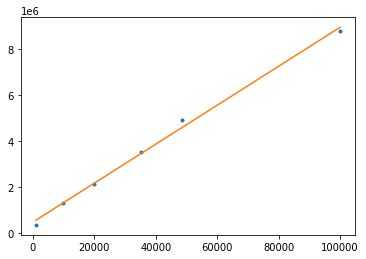

In [76]:
res_list = np.array([1,10,20,35.2,48.7,100])*10**3
res_data_list = np.array([1,10,20,352,487,100])
factor_list = []
V_ms_n = np.array([1097,2065,2615,3329,3895,4967])*10**(-6)
for i in range(len(res_list)):
    res = res_list[i]
    fres, vres = volt_freq_read('day_4_n_2\D4'+str(res_data_list[i])+'K.csv')
    v_gain, gf = average_gain()
    G_band = band_gain(cap*(1), res, gf, fres)
    temp_factor = (V_ms_n[i]**2 - v_ms_s**2)/ (4*kb*G_band)
    factor_list.append(temp_factor)

plt.plot(res_list, factor_list,'.')
t,b = np.polyfit(res_list[0:6],factor_list[0:6],1)
plt.plot(res_list, t*res_list+b)
print(t)
print('n2')

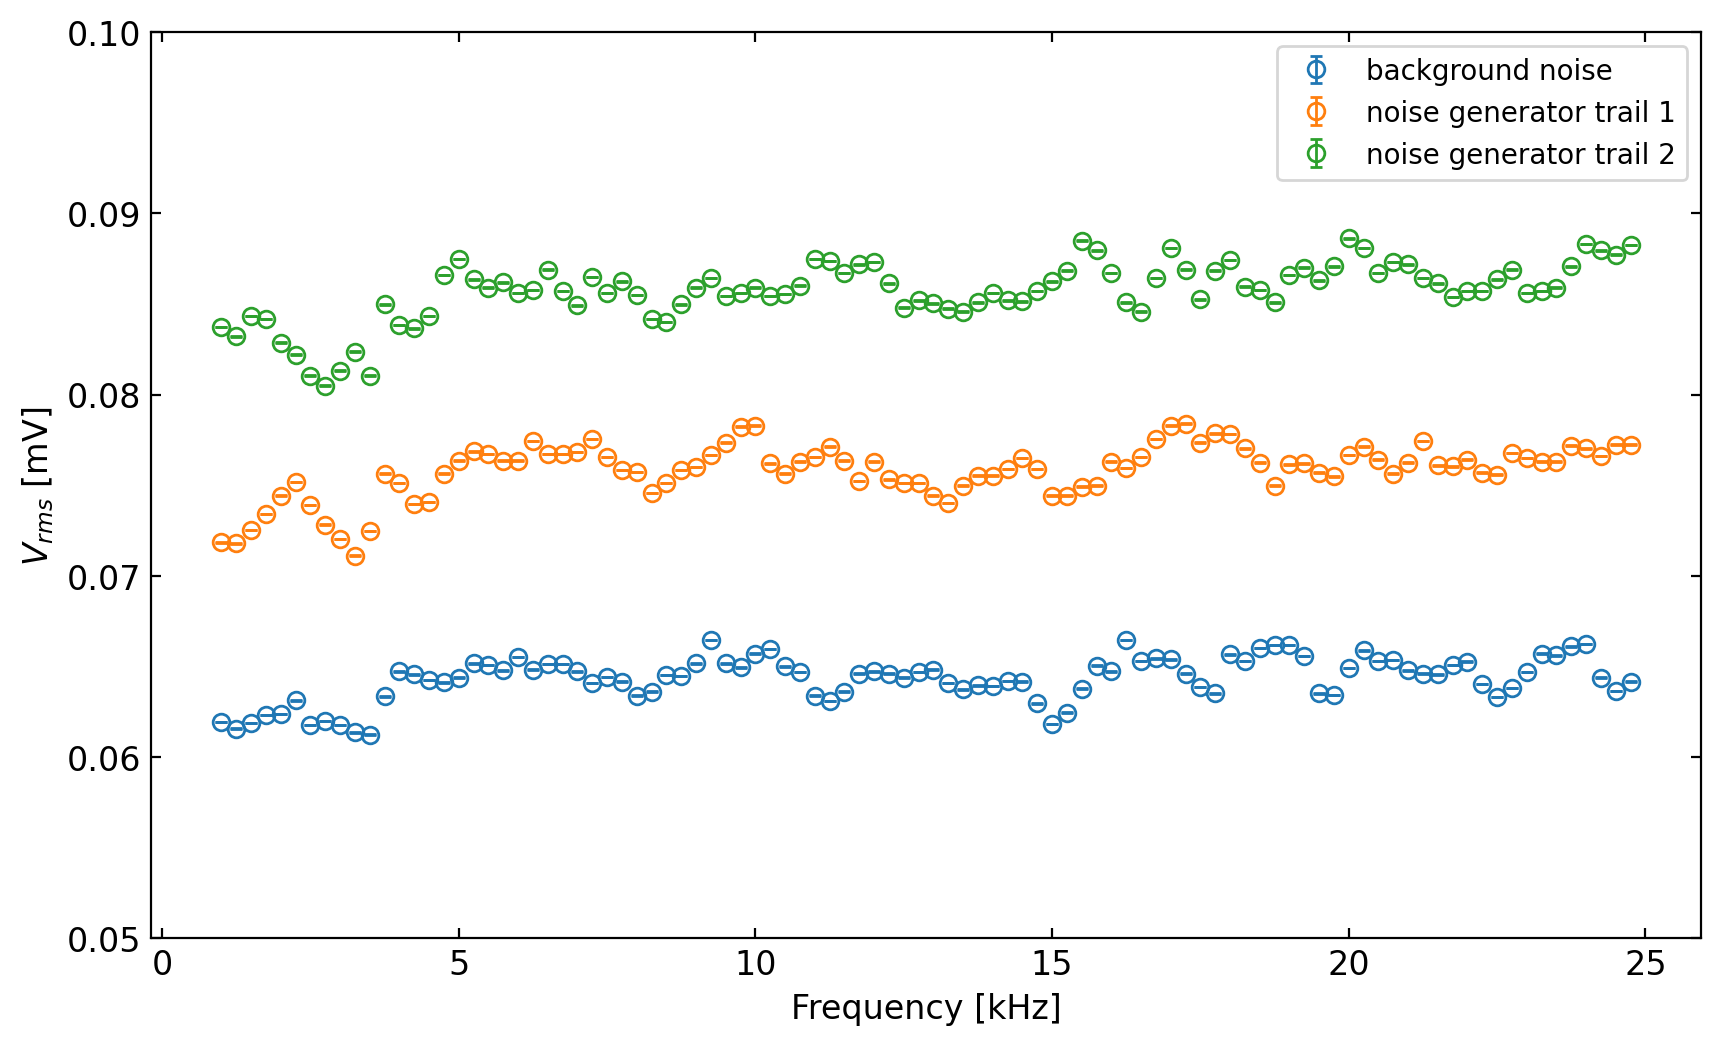

In [244]:
fres0, vres0 = volt_freq_read('day_4_res\D4'+'N'+'.csv')
fres1, vres1 = volt_freq_read('day_4_gain\D4'+'R2'+'.csv')
fres2, vres2 = volt_freq_read('day_4_res\D4'+'WD'+'.csv')

plt.figure(figsize=(10,6), dpi = 200)

plt.errorbar(fres0[4:100]/1000, vres0[4:100]*1000, yerr = vres0[4:100]*0.02*10**(-2)*1000, fmt = 'o',mfc = 'none',elinewidth = 1, capsize = 2, label = 'background noise')
plt.errorbar(fres1[4:100]/1000, vres2[4:100]*1000, yerr = vres1[4:100]*0.02*10**(-2)*1000, fmt = 'o',mfc = 'none',elinewidth = 1, capsize = 2, label = 'noise generator trail 1')
plt.errorbar(fres2[4:100]/1000, vres1[4:100]*1000, yerr = vres2[4:100]*0.02*10**(-2)*1000, fmt = 'o',mfc = 'none',elinewidth = 1, capsize = 2, label = 'noise generator trail 2')

plt.tick_params(bottom=True,top=True,left=True,right=True,direction='in')
plt.xlabel('Frequency [kHz]', fontsize=12)
plt.ylabel('$ V_{rms} $ [mV]',fontsize=12)
plt.ylim(0.05, 0.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(labels = ['Estimated $S_2$', 'Measured light spot position'], fontsize = 12)
plt.legend()
#plt.title('Linear fit for Boltzmann constant')
plt.show()

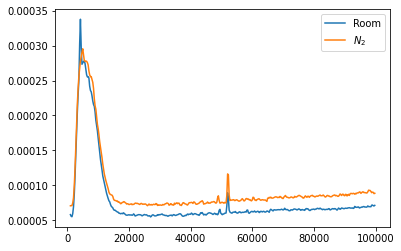

In [254]:
fres0, vres0 = volt_freq_read('day_4_res\D4'+'S'+'.csv')
fres1, vres1 = volt_freq_read('day_4_n_2\D4'+'S'+'.csv')
plt.plot(fres0[4:], vres0[4:], label = 'Room')
plt.plot(fres1[4:], vres1[4:], label = '$N_2$')
plt.legend()

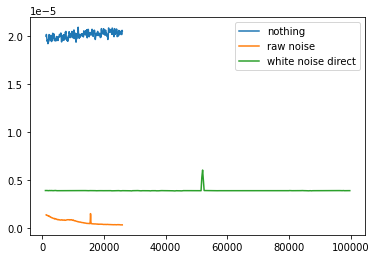

In [53]:
fres0, vres0 = volt_freq_read('day_5_gain\D5'+'N0'+'.csv')
fres1, vres1 = volt_freq_read('day_5_gain\D5'+'B'+'.csv')
fres2, vres2 = volt_freq_read('day_5_gain\D5'+'T'+'.csv')
fres3, vres3 = volt_freq_read('day_5_gain\D5'+'A0'+'.csv')
plt.plot(fres0[4:], vres0[4:], label = 'nothing')
plt.plot(fres1[4:], vres1[4:], label = 'raw noise')
plt.plot(fres2[4:], vres2[4:], label = 'white noise direct')
#plt.plot(fres3[4:], vres3[4:], label = 'white')
plt.legend()

Gain = 17.07094223391803
V_ms = 0.0005525215013806349
Temp = 58606854986989.72


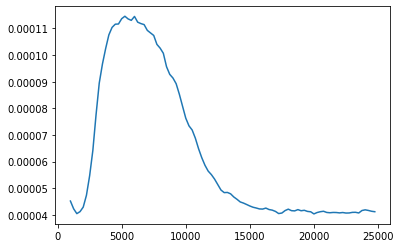

In [34]:
cap = 38*10**(-12)
res = 10*10**3

fw, vw = volt_freq_read('day_1_resistor_test\D1'+'full100khzspan'+'.csv', 0, 400)
frw, vrw = volt_freq_read('day_1_resistor_test\D1'+'noiseonly'+'.csv', 0, 400)
gw = gain_fit(fw, vw/vrw)
f10, v10 = volt_freq_read('day_1_resistor_test\D1'+'_10k'+'.csv')
G_band = band_gain(cap, res, gw, fw)
V_ms = mean_square_volt(f10, v10)
plt.plot(f10[4:100],v10[4:100])
kb = const.k
temp = (V_ms) / (4*res*kb*G_band)
print('Gain = '+str(G_band))
print('V_ms = '+str(V_ms))
print('Temp = '+str(temp))

In [83]:
1/(1/(38*10**(-12))+1/(25*10**(-12)))

1.5079365079365078e-11

1650.9369498324604


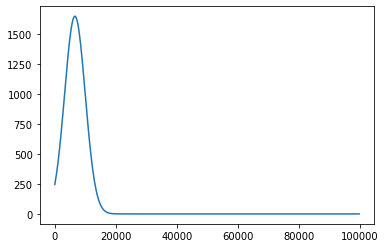

In [188]:
fg1, vg1 = volt_freq_read('day_4_gain\D4'+'G1'+'.csv')
frg1, vrg1 = volt_freq_read('day_4_gain\D4'+'R1'+'.csv')
g1 = gain_fit(fg1, vg1/vrg1)
plt.plot(fg1,g1)
print(np.max(g1))

In [77]:

        # fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharey=False,figsize=(20, 10))
        # ax0.plot(fg,v_out,'.',label = 'ampllified')
        # ax0.legend()
        # ax1.plot(fg,v_in,'.', label = 'raw')
        # ax1.legend()
        # ax2.plot(fg,(v_out/v_in)**2,'.', label = 'gain')
        # ax2.plot(fg, gf, label = 'fit')
        # ax2.vlines(x=3000, ymin = 0, ymax = np.max(gf), colors = 'pink')
        # ax2.vlines(x=10000, ymin = 0, ymax = np.max(gf),colors = 'pink')
        # ax2.legend()

[1.70188121e+10 6.14081440e+03 2.47986833e+03]


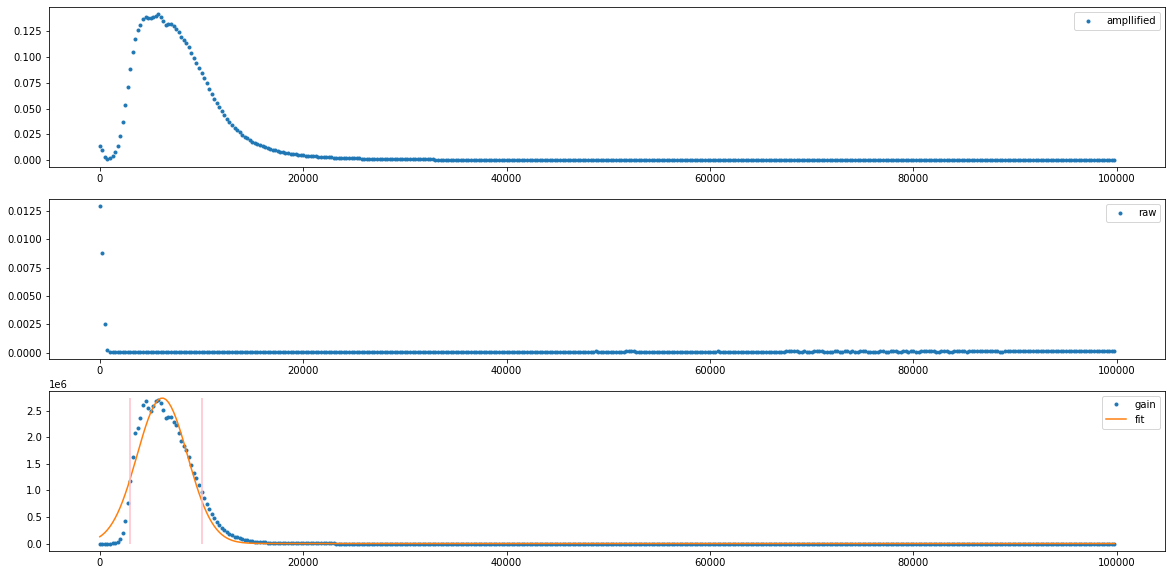

In [68]:
gf = average_gain()

In [79]:
a = np.array([1,2,3])
a+1

array([2, 3, 4])

In [41]:
f35, v35 = volt_freq_read('day_1_resistor_test\D1'+'_35_2k'+'.csv')
fr35, vr35 = volt_freq_read('day_3\D3'+'_35_2k'+'.csv')
g35 = gain_fit(f35, v35/vr35)

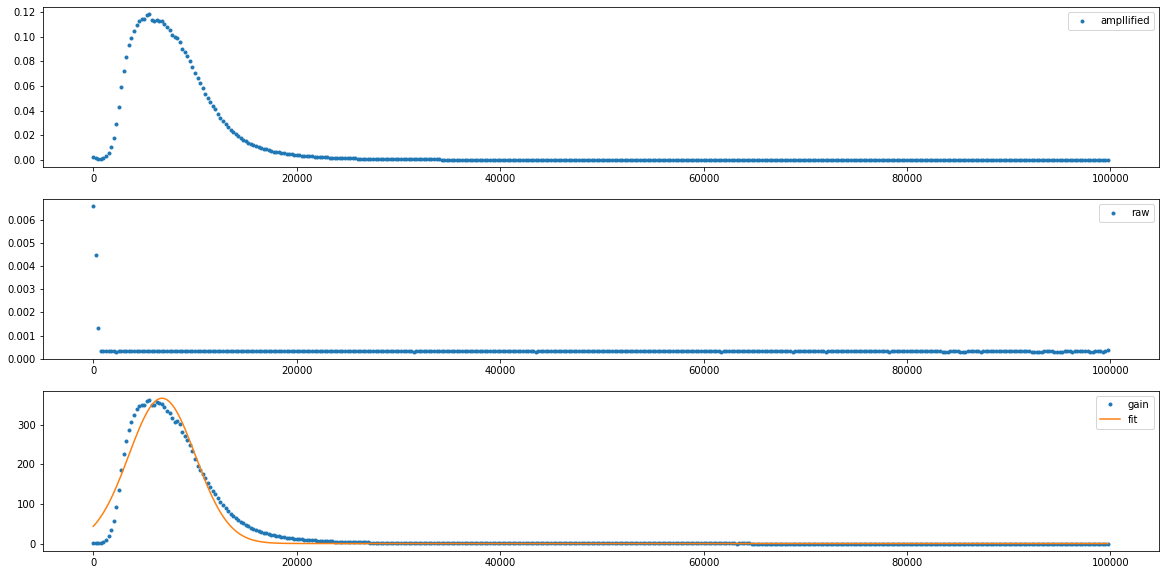

In [99]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharey=False,figsize=(20, 10))
ax0.plot(fw,vw,'.',label = 'ampllified')
ax0.legend()
ax1.plot(frw,vrw,'.', label = 'raw')
ax1.legend()
ax2.plot(fw,vw/vrw,'.', label = 'gain')
ax2.plot(fw,gw,label='fit')
ax2.legend()

In [88]:
a = np.array([1,2,3])

In [89]:
b = a*a

In [90]:
b

array([1, 4, 9])

In [177]:
np.round(1.414*10**(-4),4)

0.0001